# This is a public notebook example on using the explicit Jacobi iteration for the 2D electrostatic potential Problem.

### Following Code focuses on Multiprocessing the explicit Jacobi method on CPU using the cython.parallel.prange function

We begin by loading the Cython extension and the appropriate modules.
~ Note> The multiprocessing module does not work properly in the Jupyter notebook

We define all appropriate functions:

- The 'display' function uses the PIL.Image and takes a 2D array as input to translate into an image. The np.uint8 is the color scheme and bit depth

- The 'jacobi_iteration' performs one full sweep of a given array representation. It has no return so we define it as a void function. It takes as input a 2D array A of 64bit float numbers, and an integer Mask. The Mask serves as a literal Masking method for Dirichlet boundary conditions. Where mask[i,j] = 0 the function will not iterate over. These represent constant values in our Potential A (hence Dirichlet boundary conditions). The Method is being worked on to incorporate Neuman and Mixed B.C. This is where the Multiprocessing happens. There are 2 ways of doing this. Row-Major or Column-Major. You can assign the prange operator in the first for loop. In this case one core will be occupied iterating a whole column by itself, while other cores iterate the next Columns independantly. This is the Row-Major case. In puting the prange operator in the second for loop, the core will iterate each element of the Column independently (remember for1 iterates rows, for2 iterates inside columns), and essentially the next Row gets iterated when all core-workers are done doing this single Column.
    ~The reason why you should put the prange in the First For loop is simple. The overhead to call CPU workers might be larger than the amount of time needed to iterate a whole column. So by the time Windows calls for example 15 more CPU cores to solve Algebra on the second iteration of the 'j' loop, that 1 Core that started iterating that 'j' Column is already done doing the Algebra that the other 16 cores are getting called for, and the second for loop over 'i' begins since the'j' are done. Now Windows has to spend the same amount of time calling 15 Cores while Core 1 already finished iteration nr.2 over 'i'. Putting prange in the first loop mitigates this, because we are guaranteed that the other cores are called to iterate over 'i' and not over 'j' (You have no conflict of interest).
       Note!!! => Because this function iterates from 1 => n/m-1 It always represents edges as Dirichlet B.c. This allows us to use them as Ghost Indeces for Neuman B.c where we need to adjust the values to match a derivative of choice.
       For example A[0] = A[3] means
$$
\dfrac{d}{dx}=0
$$
    In this specific function i will use the Boundaries as static Dirichlet conditions with cosinus functions on them.
    Yes color scaling in PIL is hell but matplotlib does not support full resolution render and saving with simple syntax.
- The 'Jacobi_fx' uses the 'jacobi_iteration' continiously until a certain number of maximum iterations is reached, or until a convergence criterion is reached. This is represented by the 'error' variable. It is measured by doing the L2 Norm of the array, saving it, then calculating the difference with the L2 norm of the next iteration. Once the L2 norm is small enough (represented by our given error) the iterations stop. The function returns the potential A, the number of iterations and the reached error.

The 'Jacobi_fx' has to be defined a cPython function because it will ideally be called in another script if you are working with .pyx files or in other Cells if you are using Jupyter. Same argument for the 'display' function


Testing is done by creating an array of 4K resolution (2160 x 3840 => 8,294,400 elements) (on my AMD 5950x with all cores at 4.6 Ghz this took around 4 minutes) and a Mask of the appropriate size.

The potential is filled with 4 circular Electrodes in symmetrical positions set to 10 Volts and 5 Volts. The indeces where these Electrodes are represented in the Potential Array in, are also representing of ='0' Elements in our Mask. After all the Electrodes are Static and we only need to calculate the Electric Field/Potential around them. (They represent Dirichlet conditions). The Edges of the

In [1]:
%load_ext Cython

In [2]:
%%cython -a

cimport cython
from cython.parallel import prange
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from PIL import Image



cpdef display(field):
    return Image.fromarray(np.uint8(field))



@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cdef void jacobi_iteration(double[:,:] A, int[:,:] mask):
    cdef int i, j, n, m
    cdef double tmp
    n, m = A.shape[0], A.shape[1]
    for i in prange(1, n-1, nogil=True):
        for j in range(1, m-1):
            if mask[i, j]:
                tmp = 0.25 * (A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1])
                A[i, j] = tmp

                
                
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.initializedcheck(False)
@cython.nonecheck(False)
cpdef Jacobi_fx(double[:,:] A, int[:,:] mask, int max_iterations, double error):
    cdef int i, n, m, iteration
    cdef double norm, norm_prev, tmp_error
    norm_prev = 0
    norm = 0
    iteration = 0
    n, m = A.shape[0], A.shape[1]
    for i in range(max_iterations):
        norm = np.linalg.norm(A)
        jacobi_iteration(A, mask)
        tmp_error = abs(norm - norm_prev)
        norm_prev = norm
        iteration = iteration + 1
        if tmp_error < error:
            break
    return A, tmp_error, iteration




In [3]:
# Create potential array filled with zeros
# ATTENTION: TAKE CARE OF THE RESOLUTION SIZE. THE JACOBI ITERATION IS INEFFICIENT EVEN MULTIPROCESSED IN CYTHON
# ATTENTION: ALTERNATIVELY YOU CAN DEFINE OUR PARAMS AT FLOAT32 
potential = np.zeros((2160, 3840))

# Create mask array filled with ones
mask = np.ones((2160, 3840), dtype=int)

# Get center coordinates
center_x1, center_y1 = potential.shape[0] // 4, potential.shape[1] // 2
center_x2, center_y2 = potential.shape[0] // 2, potential.shape[1] // 4
center_x3, center_y3 = potential.shape[0] // 1.3333, potential.shape[1] // 2
center_x4, center_y4 = potential.shape[0] // 2, potential.shape[1] // 1.3333
# Create circular mask
# Create circular mask
for i in range(potential.shape[0]):
    for j in range(potential.shape[1]):
        if (i - center_x1)**2 + (j - center_y1)**2 <= 150**2:
            mask[i, j] = 0
            potential[i, j] = 5.
        elif (i - center_x2)**2 + (j - center_y2)**2 <= 150**2:
            mask[i, j] = 0
            potential[i, j] = 10.
        elif (i - center_x3)**2 + (j - center_y3)**2 <= 150**2:
            mask[i, j] = 0
            potential[i, j] = 5.
        elif (i - center_x4)**2 + (j - center_y4)**2 <= 150**2:
            mask[i, j] = 0
            potential[i, j] = 10.



### Now to display the results we use our display function with PIL

In [4]:

testside = np.linspace(0.0, 2*np.pi, num=2160)
testup = np.linspace(0.0, 2*np.pi, num=3840)

potential[:,0]=5*(np.cos(2*testside) + 1.0)
potential[:,-1]=5*(np.cos(2*testside) + 1.0)
potential[0,:]=5*(np.cos(2*testup) + 1.0)
potential[-1,:]=5*(np.cos(2*testup) + 1.0)

In [5]:
#Great success in edition those boundaries
potential[0,:]

array([10.        ,  9.99997321,  9.99989285, ...,  9.99989285,
        9.99997321, 10.        ])

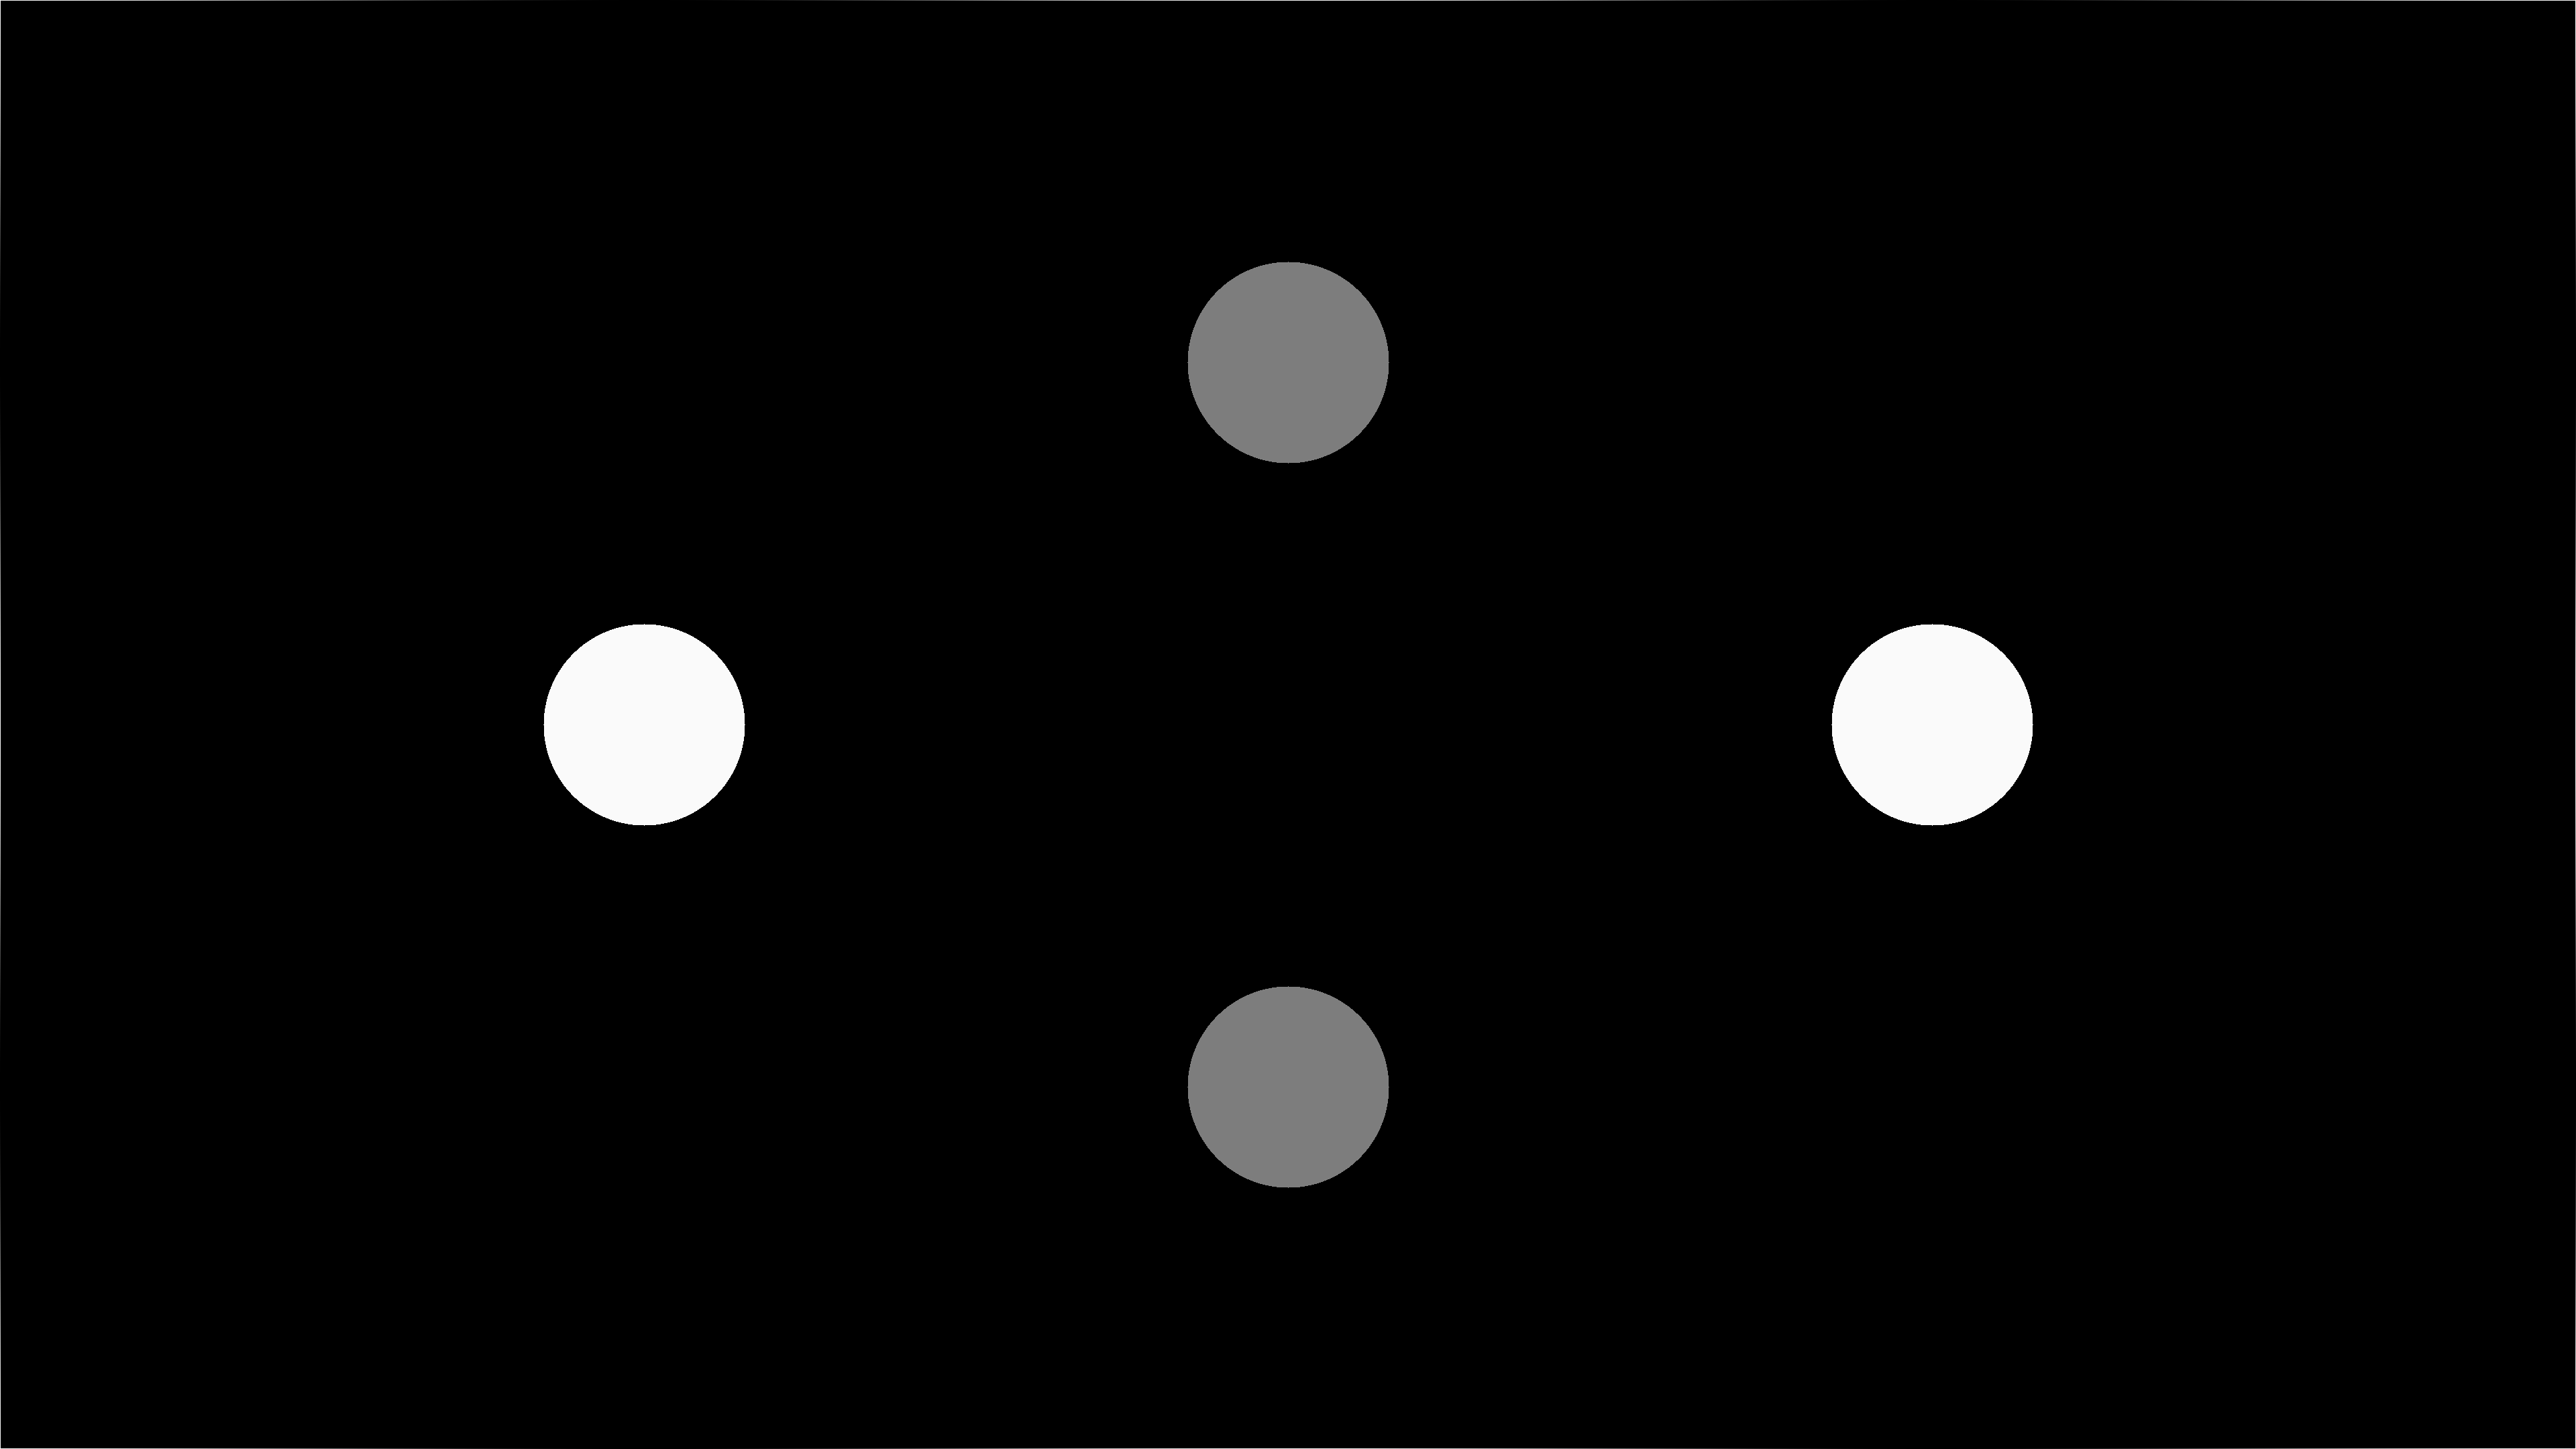

In [6]:
display(potential*25)

#The Reason we multiply the potential by 25 is because of Color scaling in PIL. We will not do this operation when we start-
#-the jacobi iterations. Only when we use our 'display' function to render

## This is how the initial Potential and the Mask look like. The Electrodes on the sides at 10 Volts and the Vertical ones at 5 Volts. On the sides i have put as mentioned static oscillating boundary Conditions to make the overall potential more interesting. 

## Now it is time to render.

In [7]:
%%time
iterations = 6000
error = 0.1
A = Jacobi_fx(potential, mask, iterations, error)


Wall time: 3min 22s


### As we can see it took around 3 mins 22 seconds with a bit of overhead from Monitoring software and screenshoting. This is not bad considering the Jacobi is the SLOWEST converging method for solving large systems of Linear Equations.

### The whole Matrix and software running (only notebook) took around 9.8 GB of RAM and used a single thread per CPU core, giving an overallutilization of 50-52% at Clocks of 4.5-4.7 Ghz on 16 physical Cores, 32 Threads.

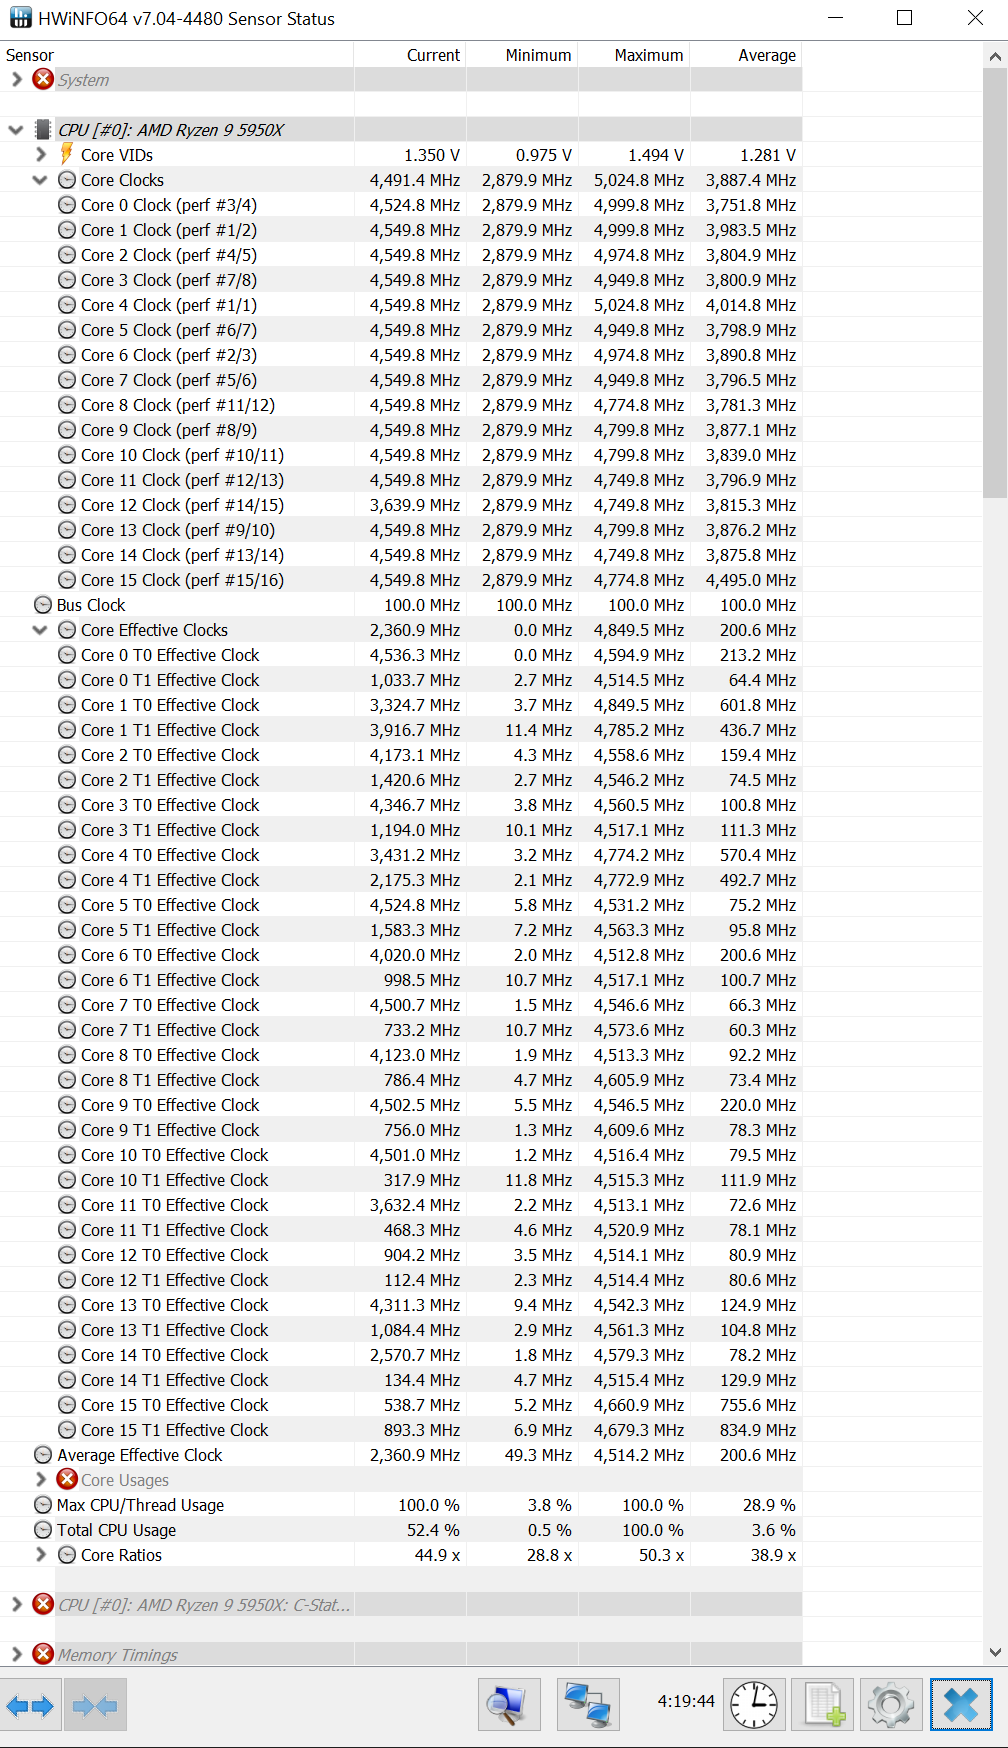

In [9]:
A[1], A[2]

(0.15586385805181635, 6000)

### !!NOTE: it seems above the function did all 6000 iterations and came to an error of 0.155 only.

In [11]:
A[0] 
#This is our final array to render. Our resulting potential.

<MemoryView of 'ndarray' at 0x15d92375700>

Don't forget we multiply by 25 for PIL color scaling and convert the Memoryview of Cython to an actual array using the numpy.asarray method.

In [12]:
test = 25*np.asarray(A[0])
np.max(test)

250.0

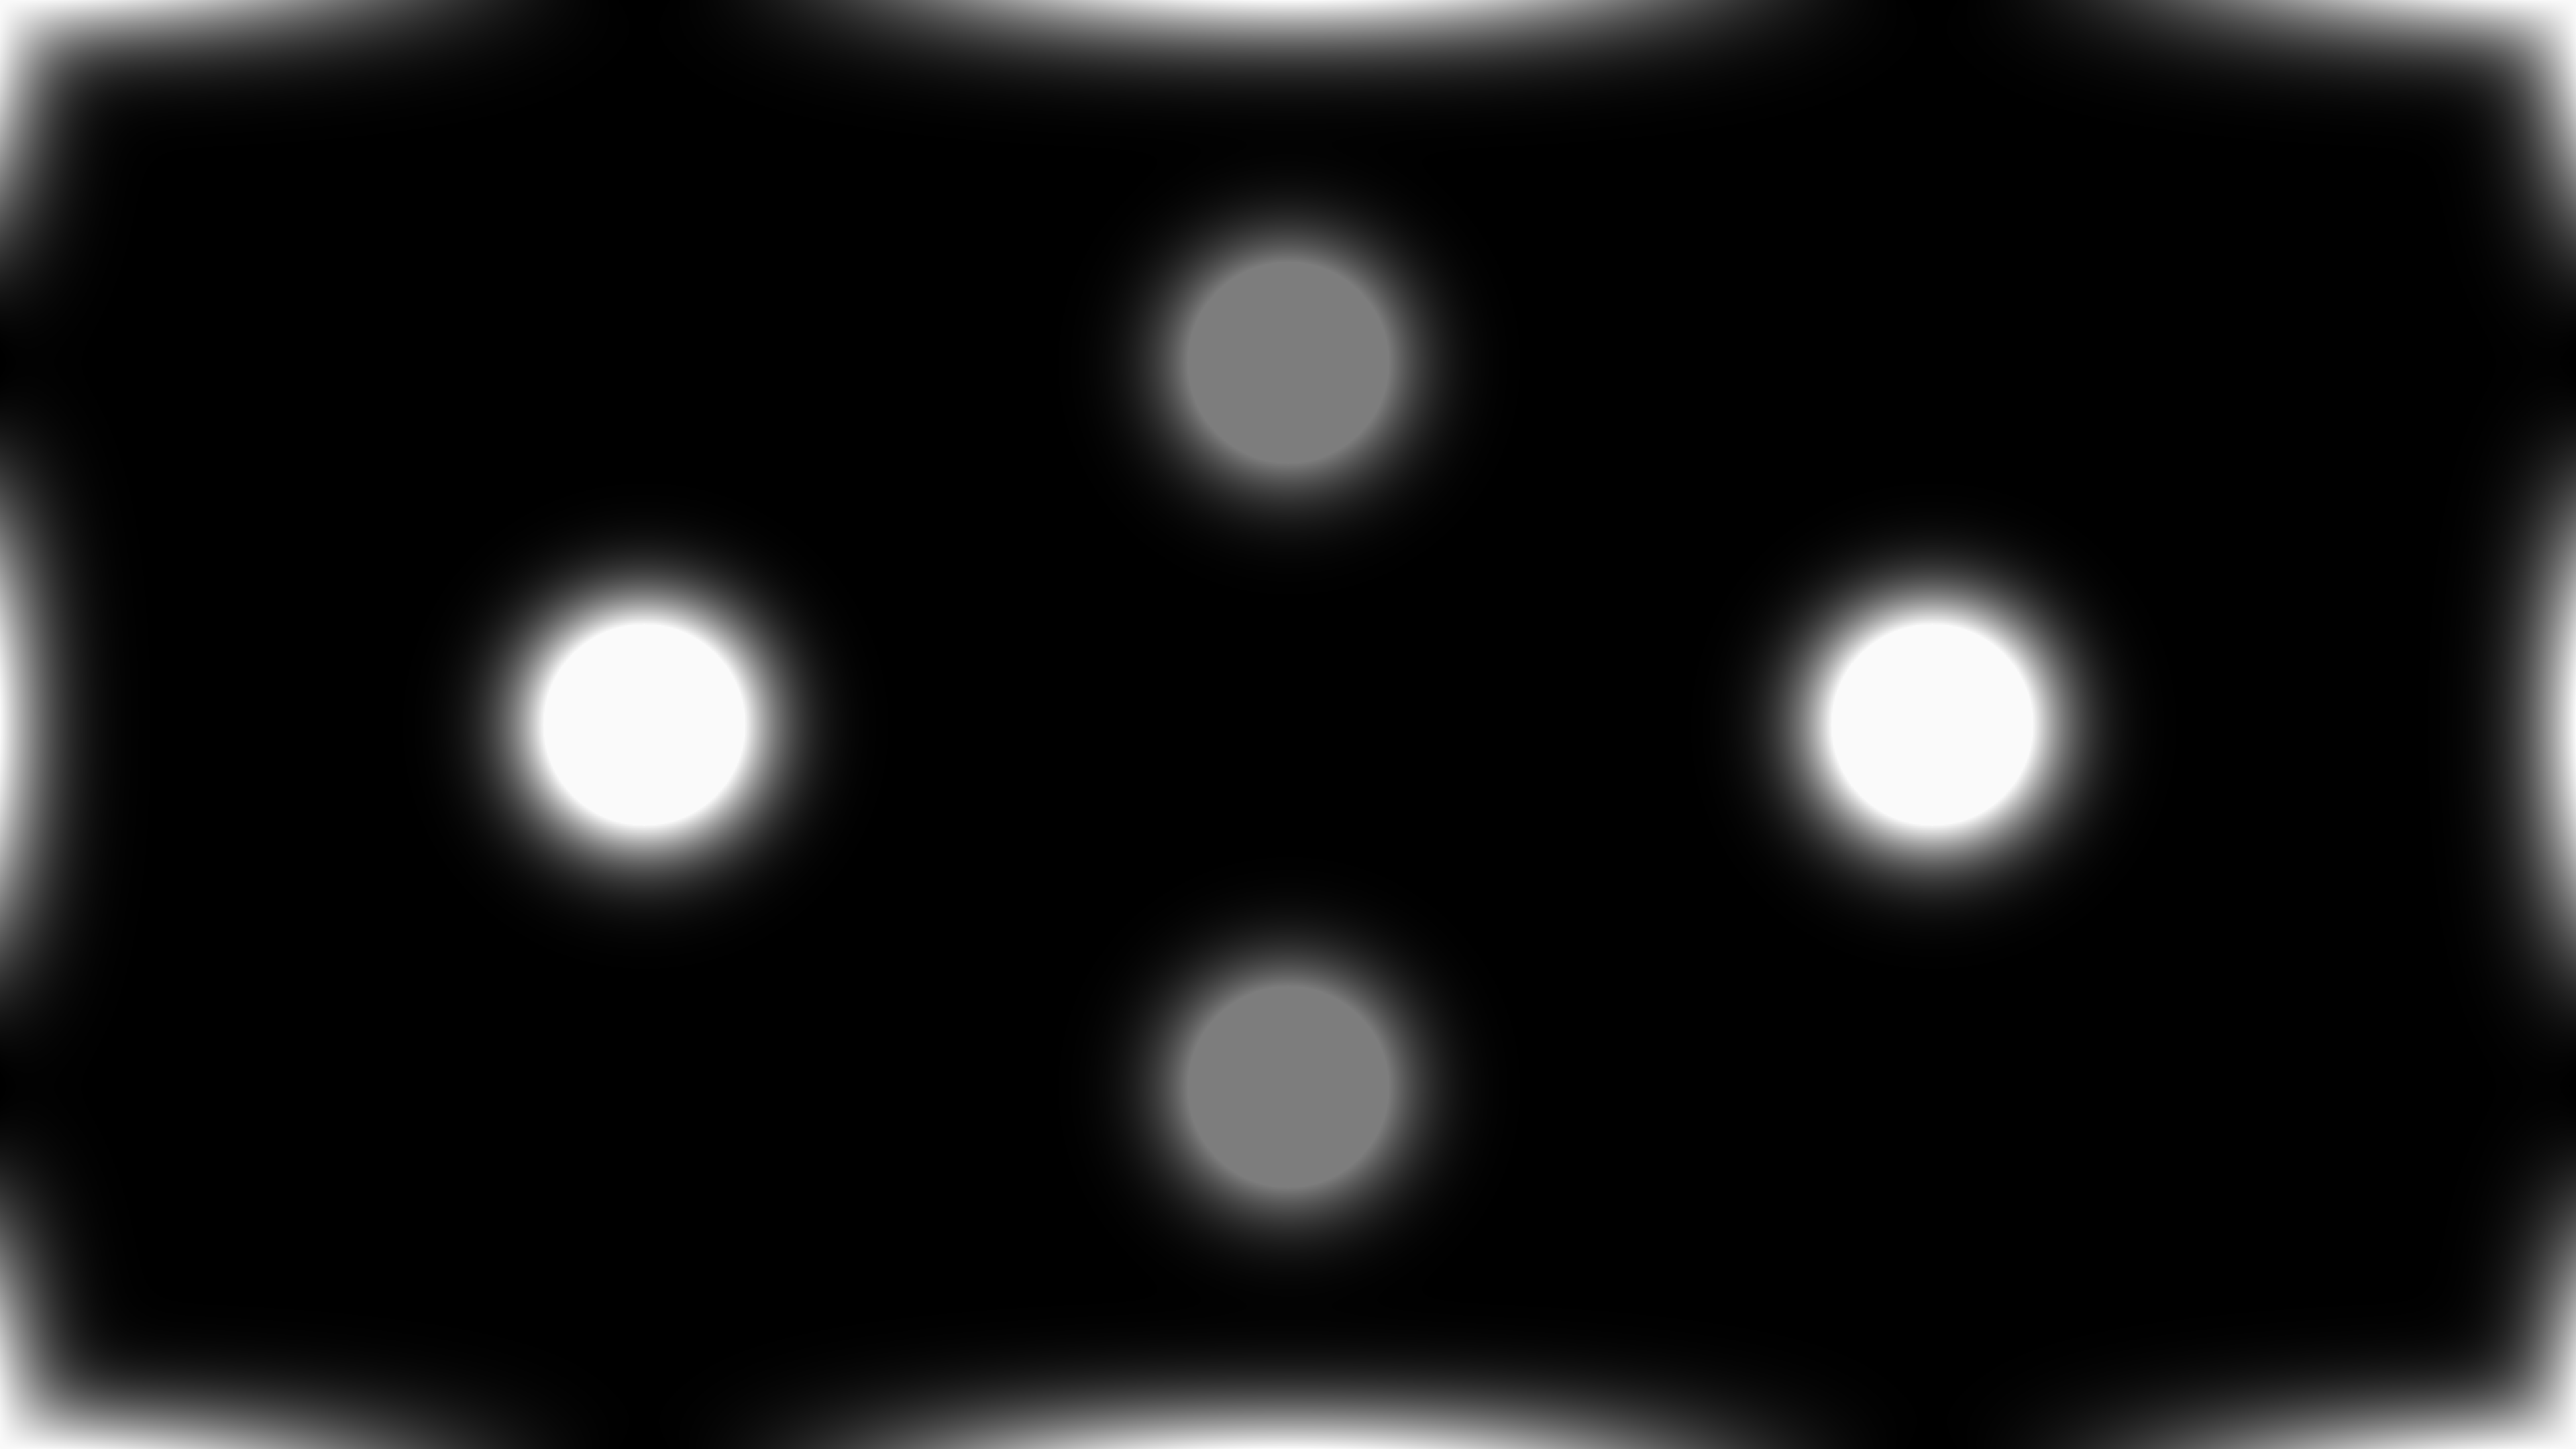

In [13]:
display(test)

This is a nice result. We can calculate the Gradient and plot the Electric Vector field thanks to some already taken care of methods.

In [27]:
import matplotlib.pyplot as plt



In [29]:
#field lines
dy, dx = np.gradient(A[0])
xv, yv = np.meshgrid(np.linspace(0, 1, 3840), np.linspace(0, 1, 2160))


Text(0.5, 1.0, 'Electric field of the Cython Jacobi-method calculated potential')

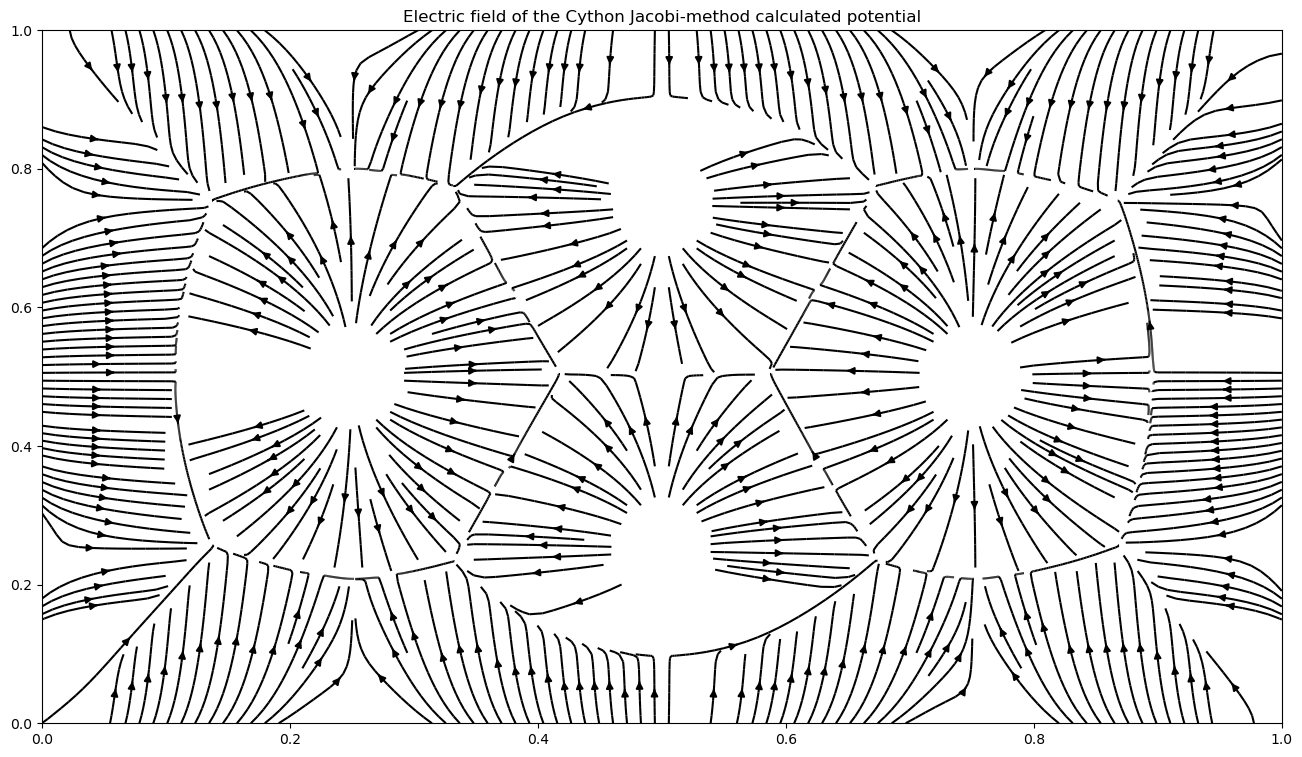

In [32]:
plt.figure(figsize = (16, 9))
plt.streamplot(xv, yv, -dx, -dy, density=3, color='black')
#yes they have to be -dx -dy don't ask me why as numpy ^-^
plt.title("Electric field of the Cython Jacobi-method calculated potential")
#field lines flow from the positive potential to negative

We can see interesting features in the field. The Electrodes at higher potential on the sides have denser electric fields. More lines represent them.